In [3]:
def getATL10data(fileT, beam='gt1r', maxFreeboard=10):
    """ Pandas/numpy ATL10 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

	I've picked out the variables from ATL10 I think are of most interest to sea ice users, 
    but by no means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL10 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you might want
    
	Args:
		fileT (str): File path of the ATL10 dataset
		beamStr (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        maxFreeboard (float): maximum freeboard (meters)

	returns:
        pandas dataframe

	"""

    print('ATL10 file:', fileT)
    
    f1 = h5py.File(fileT, 'r')
    
    freeboard=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]

    freeboard_confidence=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_confidence'][:]
    freeboard_quality=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_quality_flag'][:]
    
    lons=f1[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:]
    lats=f1[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:]
    deltaTime=f1[beam]['freeboard_beam_segment']['beam_freeboard']['delta_time'][:]-f1[beam]['freeboard_beam_segment']['beam_freeboard']['delta_time'][0]
    
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=f1['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    temp = ut.convert_GPS_time(atlas_epoch[0] + deltaTime, OFFSET=0.0)
    
    
    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')
    dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
                        'hour':hour, 'minute':minute, 'second':second})
    
    dF = pd.DataFrame({'freeboard':freeboard, 'lon':lons, 'lat':lats, 'delta_time':deltaTime,
                      'year':year, 'month':month, 'day':day})
    
    dFtimepd=pd.to_datetime(dFtime)
    dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
    
    
    dF = dF[(dF['freeboard']>0)]
    dF = dF[(dF['freeboard']<maxFreeboard)]
    # Decide here if we want to also filter based on the confidence and/or quality flag
    
    # Reset row indexing
    dF=dF.reset_index(drop=True)

    return dF

In [5]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import h5py
import s3fs
import readers as rd
import xarray as xr
import utils as ut

#ATL10-01_20181202120647_09910101_001_01.h5
localFilePath='/home/jovyan/atl10/ATL10-01_20181202120647_09910101_001_01.h5'
beamStr='gt1r'

In [6]:
dF10 = getATL10data(localFilePath, beam=beamStr)
dF10.head(5)

ATL10 file: /home/jovyan/atl10/ATL10-01_20181202120647_09910101_001_01.h5


,freeboard,lon,lat,delta_time,year,month,day,datetime
0,0.159433,-1.227177,80.882380,10.965044,2018,1,1,2018-01-01 00:00:10
1,0.205310,-1.227477,80.882584,10.968337,2018,1,1,2018-01-01 00:00:10
2,0.154006,-1.227855,80.882839,10.972484,2018,1,1,2018-01-01 00:00:10
3,0.133759,-1.228193,80.883067,10.976182,2018,1,1,2018-01-01 00:00:10
4,0.139481,-1.228461,80.883246,10.979089,2018,1,1,2018-01-01 00:00:10


In [62]:
#SMOS_Icethickness_v3.1_north_20181202.nc
from netCDF4 import Dataset
# plot SMOS ice thickness
fname='/home/jovyan/Floes-are-Swell/data/SMOS_Icethickness_v3.1_north_20181202.nc'
fh=Dataset(fname,mode='r')
lonthic = fh.variables['longitude'][:]
latthic = fh.variables['latitude'][:]
thic = fh.variables['sea_ice_thickness'][0,:,:]
thicuncertainty = fh.variables['ice_thickness_uncertainty'][0,:,:]
mask = (thicuncertainty < 1.0 ) & ( thic > 0 )
latthic, lonthic, thic = latthic[mask], lonthic[mask], thic[mask]

FigureCanvasNbAgg()

1.1002865 0.020588683
(35419,) (35419,) (35419,)


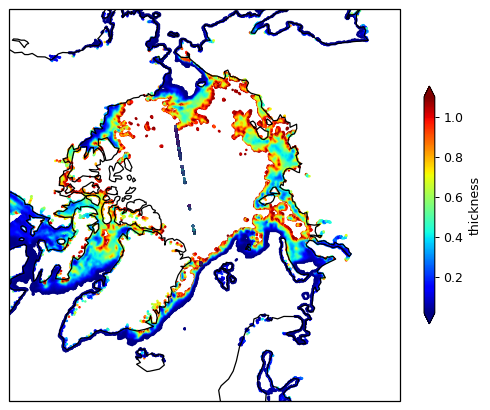

In [64]:
%matplotlib widget
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
print(thic.data.max(), thic.data.min())
print(thic.shape, lonthic.shape, latthic.shape)
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
sc = plt.scatter(lonthic, latthic, s=1, c=thic, cmap='jet', transform=ccrs.PlateCarree())
#plt.pcolor(lonthic, latthic, thic, cmap='coolwarm_r', vmin=0,vmax=0.5,transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(sc, label='thickness', shrink=0.5, extend='both')
plt.scatter(dF10['lon'], dF10['lat'],c=dF10['freeboard'], s=1, cmap='viridis', vmin=0,vmax=1, transform=ccrs.PlateCarree())


# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

In [17]:
def getATL07data(fileT, numpy=False, beam='gt1r', maxElev=1e6):
    """ Pandas/numpy ATL07 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)


    I've picked out the variables from ATL07 I think are of most interest to sea ice users, but by no means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL07 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you might want
    
    Args:
        fileT (str): File path of the ATL07 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beam (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        maxElev (float): maximum surface elevation to remove anomalies

    returns:
        either: select numpy arrays or a pandas dataframe

    """
    
    # Open the file
    try:
        ATL07 = h5py.File(fileT, 'r')
    except:
        return 'Not a valid file'
    
    lons=ATL07[beam+'/sea_ice_segments/longitude'][:]
    lats=ATL07[beam+'/sea_ice_segments/latitude'][:]
    
    # Along track distance from the equator crossing to the segment center. 
    # I removed the first point so it's relative to the start of the beam
    along_track_distance=ATL07[beam+'/sea_ice_segments/seg_dist_x'][:] - ATL07[beam+'/sea_ice_segments/seg_dist_x'][0]
    # Height segment ID (10 km segments)
    height_segment_id=ATL07[beam+'/sea_ice_segments/height_segment_id'][:] 
    #  Nathan says it's the number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=ATL07['/ancillary_data/atlas_sdp_gps_epoch'][:] 

    # Conversion of delta_time to a calendar date
    temp = ut.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')
    
    # put this all into a dataframe that will be used to generate a datetime column later.
    # Can also just add these in to the dataframe as separate columns
    dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
                        'hour':hour, 'minute':minute, 'second':second})
    
    
    # Primary variables of interest
    
    # Beam segment height
    elev=ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:]
    # Flag for potential leads, 0=sea ice, 1 = sea surface
    ssh_flag=ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] 
    
    #Quality metrics for each segment include confidence level in the surface height estimate, 
    # which is based on the number of photons, the background noise rate, and the error measure provided by the surface-finding algorithm.
    # Height quality flag, 1 for good fit, 0 for bad
    quality=ATL07[beam+'/sea_ice_segments/heights/height_segment_quality'][:] 
    
    elev_rms = ATL07[beam+'/sea_ice_segments/heights/height_segment_rms'][:] #RMS difference between modeled and observed photon height distribution
    seg_length = ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:] # Along track length of segment
    height_confidence = ATL07[beam+'/sea_ice_segments/heights/height_segment_confidence'][:] # Height segment confidence flag
    reflectance = ATL07[beam+'/sea_ice_segments/heights/height_segment_asr_calc'][:] # Apparent surface reflectance
    ssh_flag = ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] # Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = ATL07[beam+'/sea_ice_segments/heights/height_segment_type'][:] # 0 = Cloud covered
    gauss_width = ATL07[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:] # Width of Gaussian fit

    
    # Geophysical corrections
    # NOTE: All of these corrections except ocean tides, DAC, 
    # and geoid undulations are applied to the ATL03 photon heights.
    
    # AVISO dynamic Atmospheric Correction (DAC) including inverted barometer (IB) effect (±5cm)
    dac = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_dac'][:] 
    # Solid Earth Tides (±40 cm, max)
    earth = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_earth'][:]
    # Geoid (-105 to +90 m, max)
    geoid = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_geoid'][:] 
    # Local displacement due to Ocean Loading (-6 to 0 cm)
    loadTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_load'][:] 
    # Ocean Tides including diurnal and semi-diurnal (harmonic analysis), 
    # and longer period tides (dynamic and self-consistent equilibrium) (±5 m)
    oceanTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_ocean'][:]
    # Deformation due to centrifugal effect from small variations in polar motion 
    # (Solid Earth Pole Tide) (±1.5 cm, the ocean pole tide ±2mm amplitude is considered negligible)
    poleTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_pole'][:] 
    # Mean sea surface (±2 m)
    # Taken from ICESat and CryoSat-2, see Kwok and Morison [2015])
    mss = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]
    
    photon_rate = ATL07[beam+'/sea_ice_segments/stats/photon_rate'][:]
    
    # Estimated background rate from sun angle, reflectance, surface slope
    background_rate = ATL07[beam+'/sea_ice_segments/stats/backgr_calc'][:]
    
    ATL07.close()
    
    
    if numpy:
        # list the variables you want to output here..
        return lons,lats, elev, ssh_flag
    
    else:
        dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag,
                          'quality_flag':quality,'mss':mss,
                           'delta_time':delta_time,
                           'along_track_distance':along_track_distance,
                           'height_segment_id':height_segment_id, 
                           'photon_rate':photon_rate,'background_rate':background_rate})
   #     dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag})
         # Add the datetime string
       # dFtimepd=pd.to_datetime(dFtime)
       # dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
        
        # Filter out high elevation values 
        dF = dF[(dF['elev']<maxElev)]
        # Reset row indexing
        dF=dF.reset_index(drop=True)
        return dF





In [21]:
beamStr='gt1r'
#localFilePath='/home/jovyan/Floes-are-Swell/data/processed_ATL07-01_20181121010613_08160101_001_01.h5'
localFilePath='/home/jovyan/Floes-are-Swell/data/ATL07-01_20181202120647_09910101_001_01.h5'
dF07=getATL07data(localFilePath, beam=beamStr)
dF07.head()

,elev,lons,lats,ssh_flag,quality_flag,mss,delta_time,along_track_distance,height_segment_id,photon_rate,background_rate
0,0.462192,-0.272154,80.202054,0,0,34.659168,2.898887e+07,101.398046,3,0.707071,0.0
1,0.778324,-0.272983,80.202682,0,0,34.658581,2.898887e+07,173.281607,4,0.729730,0.0
2,0.839733,-0.273641,80.203171,0,0,34.658104,2.898887e+07,229.334309,5,0.780347,0.0
3,-0.566509,-0.277193,80.205887,0,0,34.655613,2.898887e+07,539.956305,9,0.743719,0.0
4,-0.322772,-0.277979,80.206472,0,0,34.655079,2.898887e+07,606.949130,10,0.729282,0.0


FigureCanvasNbAgg()

1.1002865 0.020588683
(35419,) (35419,) (35419,)


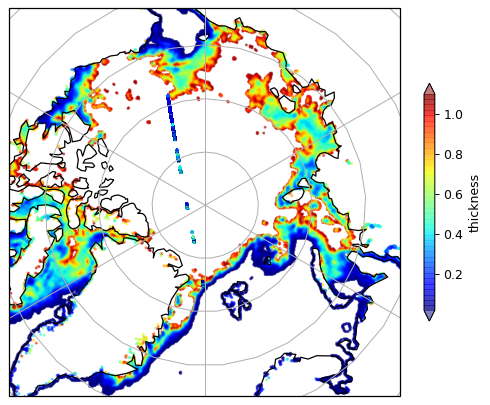

In [77]:
%matplotlib widget
#%matplotlib inline
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
print(thic.data.max(), thic.data.min())
print(thic.shape, lonthic.shape, latthic.shape)
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))

sc = plt.scatter(lonthic, latthic, s=2, c=thic, cmap='jet', alpha=0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.colorbar(sc, label='thickness', shrink=0.5, extend='both')
plt.scatter(dF10['lon'], dF10['lat'],c=dF10['freeboard'],s=2,cmap='jet',marker='^', vmin=0,vmax=1, transform=ccrs.PlateCarree())
#plt.scatter(dF07['lons'], dF07['lats'],c=dF07['elev'],s=2,cmap='jet', vmin=0,vmax=1,transform=ccrs.PlateCarree())


# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 68], ccrs.PlateCarree())

FigureCanvasNbAgg()

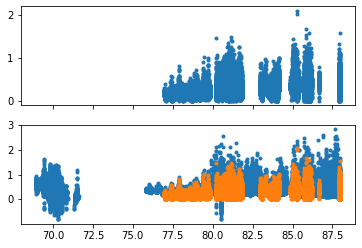

In [73]:
#%matplotlib inline
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
ax = axs[0]
ax.plot(dF10['lat'],dF10['freeboard'],'.')
#ax.plot(dF10['along_track_distance'],dF10['freeboard'],'.')
ax = axs[1]
#ax.plot(dF10['lat'],dF10['freeboard_confidence'],'.')
ax.plot(dF07['lats'],dF07['elev'],'.')
ax.plot(dF10['lat'],dF10['freeboard'],'.')
#ax.plot(dF07['along_track_distance'],dF07['elev'],'.')

